# FoCal - VAE approach

### Set up data globals

In [1]:
from pathlib import Path

DATA_DIR = Path("./data")
dataroot_path = DATA_DIR / "InputsForML.root"

INPUT_SIZE = 3
RESPONSE_SHAPE = (105, 105)
N_ELEMENTS = 105 * 105

RESPONSE_COLUMN = "mCellsEnergy"
INPUT_COLUMNS = [
    "mPartEnergy",
    "mPartEta",
    "mPartPhi",
]

### Read inputs and responses

In [2]:
import uproot

with uproot.open(dataroot_path) as file:
    tree = file["myTree;1"]
    fullsim = tree.arrays(library="pd")

fullsim.head(8)

,mPartEnergy,mPartEta,mPartPhi,mCellsEnergy
0,421.613098,4.014187,2.053545,[[2.9238933237215903e-38 4.5914945482066956e-4...
1,624.679810,4.538766,5.687571,[[2.9238933237215903e-38 4.5914945482066956e-4...
2,295.703522,4.556715,2.661494,[[2.9238933237215903e-38 4.5914945482066956e-4...
3,1023.025085,5.100775,3.462068,[[2.9238933237215903e-38 4.5914945482066956e-4...
4,533.921265,3.878302,0.507037,[[2.9238933237215903e-38 4.5914945482066956e-4...
5,107.085495,4.020199,2.227065,[[2.9238933237215903e-38 4.5914945482066956e-4...
6,284.345673,5.395181,4.805693,[[2.9238933237215903e-38 4.5914945482066956e-4...
7,294.136353,3.800009,4.689988,[[2.9238933237215903e-38 4.5914945482066956e-4...


### Preprocess images

In [3]:
import numpy as np
import torch as torch
from sklearn.preprocessing import MinMaxScaler

responses = fullsim[RESPONSE_COLUMN].to_numpy(dtype="float32")
n_nans = np.isnan(responses).sum(axis=(1, 2)).shape[0]

print(f"Number of NaN values: {n_nans}")

responses[np.isnan(responses)] = 0
responses[responses < 0] = 0
responses[responses > 200] = 0
responses += 1e-5
responses = np.log(responses)

scaler = MinMaxScaler((0.0, 1.0))

responses = scaler.fit_transform(responses.reshape(-1, N_ELEMENTS)).reshape(
    -1, *RESPONSE_SHAPE
)

responses = torch.tensor(responses, dtype=torch.float32)
responses[responses > 1] = 1  # throws errors otherwise

Number of NaN values: 30000


### Preprocess inputs

extract inputs

In [4]:
inputs_raw = fullsim[INPUT_COLUMNS].values

Plot input value distributions

[]

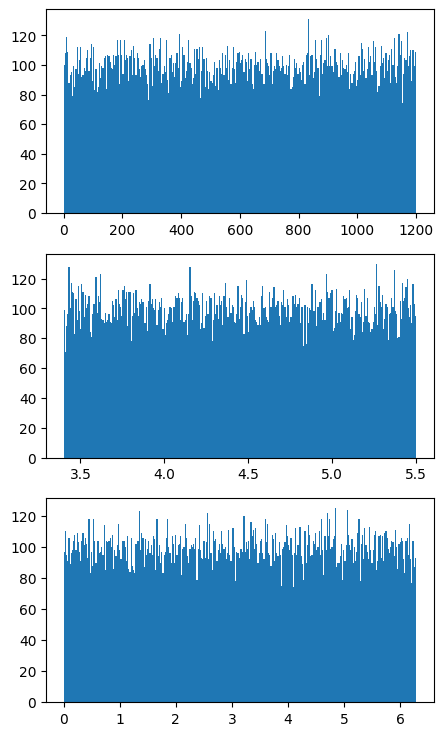

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(5, 3 * INPUT_SIZE))

for i in range(INPUT_SIZE):
    ax[i].hist(inputs_raw[:, i], bins=300)

plt.plot()

Scale inputs

In [6]:
from sklearn.preprocessing import StandardScaler

input_scaler = StandardScaler()
inputs = input_scaler.fit_transform(inputs_raw)
inputs = torch.tensor(inputs, dtype=torch.float32)

### Display example images

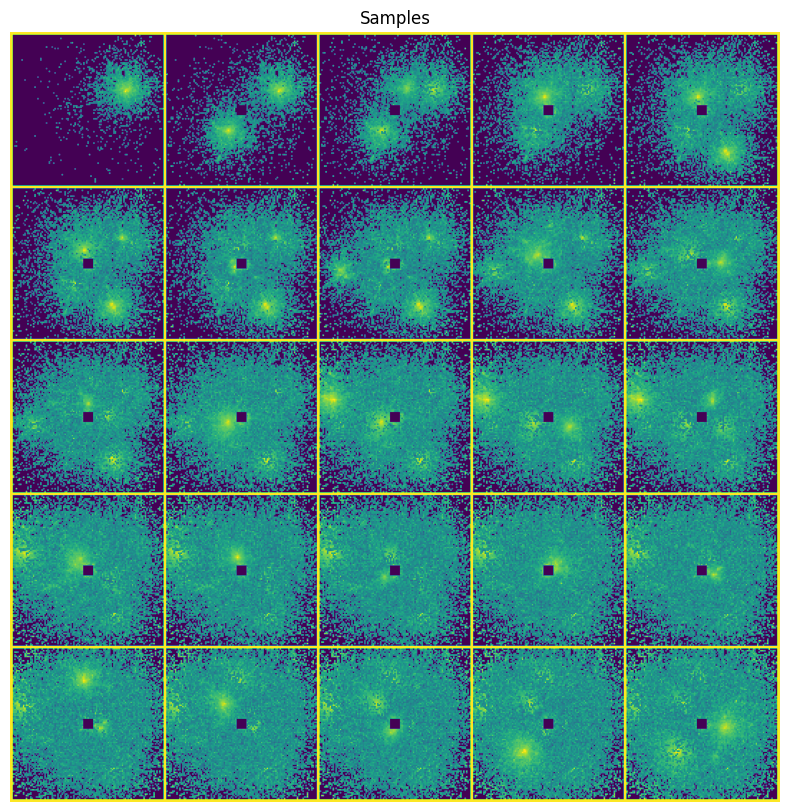

In [7]:
import torchvision.utils as vutils


def show_image_grid(
    images,
    nrow=4,
    padding=2,
    title="Samples",
    figsize=(10, 10),
):
    images = images.unsqueeze(1)
    grid = vutils.make_grid(images, nrow=nrow, padding=padding, pad_value=1)
    np_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(np_grid[:, :, 0], cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.show()


show_image_grid(responses[:25], 5, 2)

# Preapare for training

### Set up globals

In [8]:
BATCH_SIZE = 512
TRAIN_SIZE = 0.8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### Split the dataset

In [9]:
from sklearn.model_selection import train_test_split

train_responses, test_responses, train_inputs, test_inputs = train_test_split(
    responses, inputs, train_size=TRAIN_SIZE, random_state=42
)

valid_responses, test_responses, valid_inputs, test_inputs = train_test_split(
    test_responses, test_inputs, train_size=0.5, random_state=42
)

### Create dataset objects and dataloaders

In [10]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_responses, train_inputs)
valid_dataset = TensorDataset(valid_responses, valid_inputs)
test_dataset = TensorDataset(test_responses, test_inputs)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

### Create a model

In [11]:
import torch.nn as nn


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            # 105 -> 53
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            # 53 -> 27
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            # 27 -> 14
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            # 14 -> 7
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256 * 7 * 7, 256 * 7),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256 * 7, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
        )

        # Calculate the size of the flattened feature map after convolutions
        flattened_size = 128

        # Latent space
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 256 * 7),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256 * 7, 256 * 7 * 7),
            nn.Dropout(0.2),
            nn.Unflatten(1, (256, 7, 7)),
            # 7 -> 14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            # 14 -> 27
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            # 27 -> 53
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            # 53 -> 105
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2),
            # nn.Sigmoid() # we use logit loss
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

### Configure training parameters

In [33]:
epochs = 1500
latent_dim = 16
learning_rate = 1e-3

### Initialize model, optimizer and create the loss function

In [13]:
model = VAE(latent_dim=latent_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

bce_weight = 1
kld_weight = 4


def loss_function(recon_x, x, mu, logvar):
    # I noticed that the model doesn't predict high pixel values as well as low pixel values
    # The (x+1) modifier scales the loss to penalize large entropy for higher values more
    BCE = torch.sum(
        nn.functional.binary_cross_entropy_with_logits(recon_x, x, reduction="none")
        * (0.5 * x + 1)
    )
    KLD = -torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / 2

    return BCE * bce_weight, KLD * kld_weight

### Run training

In [ ]:
train_bce_list = []
train_kld_list = []
valid_bce_list = []
valid_kld_list = []

for epoch in range(epochs):
    train_bce = 0
    train_kld = 0
    train_loss = 0
    model.train()
    for batch_idx, (images, params) in enumerate(train_loader):
        images = images.unsqueeze(1).to(DEVICE)  # Add channel dimension

        optimizer.zero_grad()
        x_recon, mu, logvar = model(images)

        bce_loss, kld_loss = loss_function(x_recon, images, mu, logvar)

        train_bce += bce_loss.item()
        train_kld += kld_loss.item()

        loss = bce_loss + kld_loss

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    valid_bce = 0
    valid_kld = 0
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, params) in enumerate(valid_loader):
            images = images.unsqueeze(1).to(DEVICE)  # Add channel dimension

            optimizer.zero_grad()
            x_recon, mu, logvar = model(images)

            bce_loss, kld_loss = loss_function(x_recon, images, mu, logvar)

            valid_bce += bce_loss.item()
            valid_kld += kld_loss.item()
            loss = bce_loss + kld_loss
            valid_loss += loss.item()

    train_bce_list.append(train_bce / len(train_dataset))
    train_kld_list.append(train_kld / len(train_dataset))
    valid_bce_list.append(valid_bce / len(valid_dataset))
    valid_kld_list.append(valid_kld / len(valid_dataset))

    print(f"Epoch {epoch+1}")
    print("train")
    print(f" - BCE loss   : {train_bce / len(train_dataset):.4f}")
    print(f" - KLD loss   : {train_kld / len(train_dataset):.4f}")
    print(f" - total loss : {train_loss / len(train_dataset):.4f}")
    print("valid")
    print(f" - BCE loss   : {valid_bce / len(valid_dataset):.4f}")
    print(f" - KLD loss   : {valid_kld / len(valid_dataset):.4f}")
    print(f" - total loss : {valid_loss / len(valid_dataset):.4f}")
    print("==========")

[]

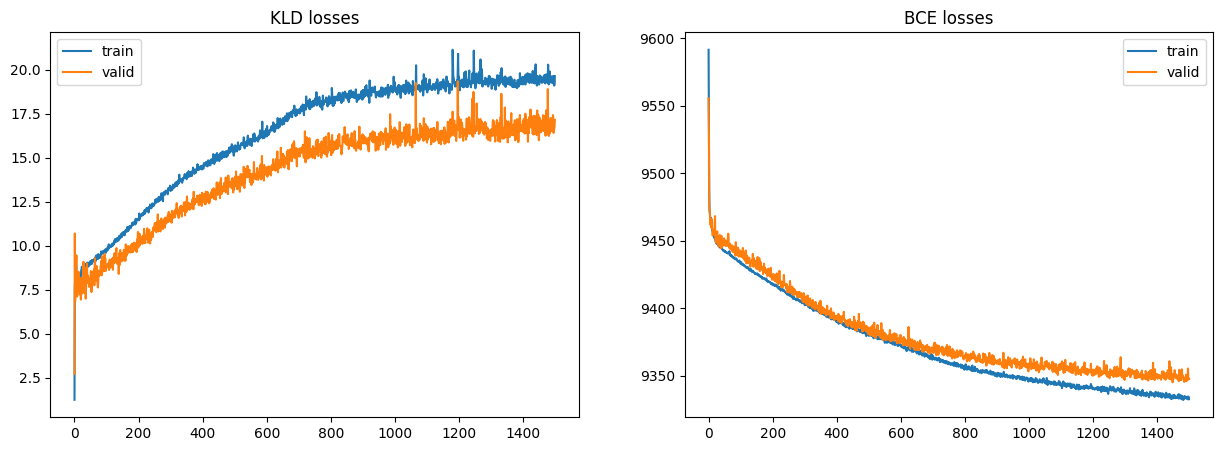

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].set_title("KLD losses")
ax[0].plot(train_kld_list, label="train")
ax[0].plot(old_losses, label="valid")
ax[0].legend()

ax[1].set_title("BCE losses")
ax[1].plot(train_bce_list, label="train")
ax[1].plot(valid_bce_list, label="valid")
ax[1].legend()

plt.plot()

In [52]:
model.eval()
x_recon, mu, logvar = model(test_dataset[3000:3001][0].unsqueeze(1).to(DEVICE))

[]

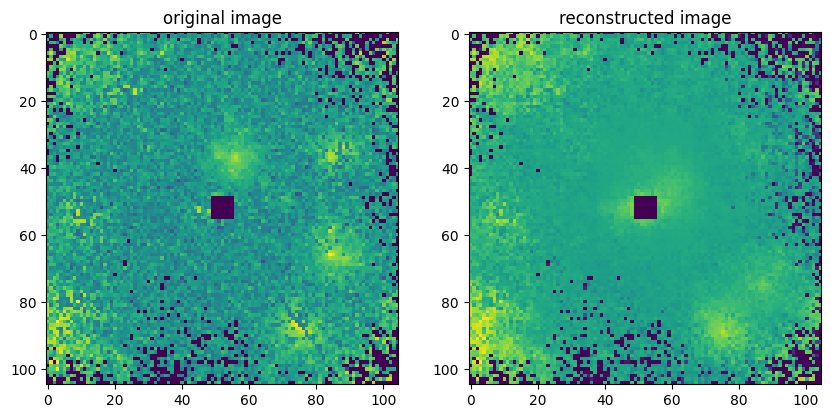

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

original = test_dataset[3000][0].squeeze().cpu().detach().numpy()
reconstructed = nn.functional.sigmoid(x_recon[0]).squeeze().cpu().detach().numpy()

ax[0].imshow(original)
ax[0].set_title("original image")
ax[1].imshow(reconstructed)
ax[1].set_title("reconstructed image")

plt.plot()